In [1]:
import time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import src.ChebNet as ChebNet
import src.CayleyNet as CayleyNet
import src.CORA as CORA
import src.CommunitiesGraph as CommunitiesGraph
import src.utils as utils

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Reload when files are changed
import importlib
importlib.reload(CayleyNet)
importlib.reload(ChebNet)
importlib.reload(CORA)
importlib.reload(CommunitiesGraph)
importlib.reload(utils)

<module 'src.utils' from '/home/infres/avalenca-22/CayleyNets/src/utils.py'>

# CORA dataset

In [4]:
# Import dataset
dataset = CORA.CORA()

Parsing files...
Done.


In [5]:
dataset.print_properties()

CORA dataset
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433


In [6]:
# Extended split of the CORA dataset
train_mask, test_mask, val_mask = utils.split_train_test_val(dataset.n, 500, 500) 

In [7]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

## CayleyNet

In [8]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 32
n_hidden_layers = 1 # number of hidden layers
r = 3 # Cayley polynomial order 

p_dropout=0.5
normalization = 'sym'
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_hidden_layers, 
                            r=r, p_dropout=p_dropout, normalization=normalization).to(device)

print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')   

# for name, param in model.named_parameters():
#     print(name, param.shape)

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 32, r=3, normalization=sym)
    (1): CayleyConv(32, 7, r=3, normalization=sym)
  )
)
Number of parameters: 322562
Number of parameters: 320993
Number of parameters: 1569


In [9]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Train the model
epochs=200
loss_values, val_score, train_score = utils.train(model, optimizer, 
                                                  edge_index, features, labels, 
                                                  train_mask, val_mask, epochs, verbose=True)

test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("\nTest accuracy {:.3f}".format(test_score))

Epoch 00 | Loss 3.949 | Accuracy (validation) 0.310 | Elapsed time: 2.11s
Epoch 01 | Loss 1.396 | Accuracy (validation) 0.424 | Elapsed time: 1.15s
Epoch 02 | Loss 0.775 | Accuracy (validation) 0.522 | Elapsed time: 1.14s
Epoch 03 | Loss 0.431 | Accuracy (validation) 0.576 | Elapsed time: 1.14s
Epoch 04 | Loss 0.256 | Accuracy (validation) 0.616 | Elapsed time: 1.14s
Epoch 05 | Loss 0.155 | Accuracy (validation) 0.662 | Elapsed time: 1.13s
Epoch 06 | Loss 0.092 | Accuracy (validation) 0.688 | Elapsed time: 1.15s
Epoch 07 | Loss 0.054 | Accuracy (validation) 0.714 | Elapsed time: 1.14s
Epoch 08 | Loss 0.032 | Accuracy (validation) 0.730 | Elapsed time: 1.14s
Epoch 09 | Loss 0.020 | Accuracy (validation) 0.732 | Elapsed time: 1.15s
Epoch 10 | Loss 0.013 | Accuracy (validation) 0.732 | Elapsed time: 1.14s
Epoch 11 | Loss 0.008 | Accuracy (validation) 0.736 | Elapsed time: 1.14s
Epoch 12 | Loss 0.006 | Accuracy (validation) 0.740 | Elapsed time: 1.13s
Epoch 13 | Loss 0.004 | Accuracy (vali

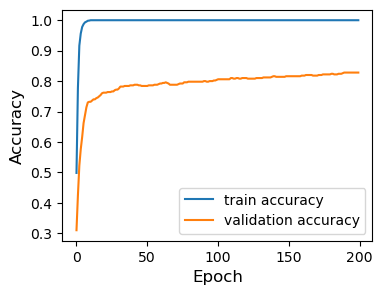

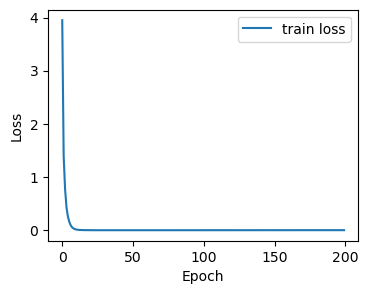

Test accuracy 0.854


In [10]:
results = {'model': 'CayleyNet',
           'dataset': dataset.name,
           'training size': sum(train_mask).cpu().numpy(),
           'validation size': sum(val_mask).cpu().numpy(),
           'test size': sum(test_mask).cpu().numpy(),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

loaded_results = utils.save_results(results, results['model']+str(results['polynomial order']), results['dataset'])

utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])
utils.plot_loss(loaded_results['loss'])
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

In [11]:
model_path = './models/'
model_name = 'CORA_CayleyNet3_2023-12-10-17-27-30'
torch.save(model.state_dict(), model_path+model_name)

# Study of the filters


In [12]:
for name, param in model.named_parameters():
    print(name, param.shape)

layers.0.h torch.Size([1])
layers.0.c.0.weight torch.Size([32, 1433])
layers.0.c.1.linear_re.weight torch.Size([32, 1433])
layers.0.c.1.linear_im.weight torch.Size([32, 1433])
layers.0.c.2.linear_re.weight torch.Size([32, 1433])
layers.0.c.2.linear_im.weight torch.Size([32, 1433])
layers.0.c.3.linear_re.weight torch.Size([32, 1433])
layers.0.c.3.linear_im.weight torch.Size([32, 1433])
layers.1.h torch.Size([1])
layers.1.c.0.weight torch.Size([7, 32])
layers.1.c.1.linear_re.weight torch.Size([7, 32])
layers.1.c.1.linear_im.weight torch.Size([7, 32])
layers.1.c.2.linear_re.weight torch.Size([7, 32])
layers.1.c.2.linear_im.weight torch.Size([7, 32])
layers.1.c.3.linear_re.weight torch.Size([7, 32])
layers.1.c.3.linear_im.weight torch.Size([7, 32])


In [13]:
model.state_dict()

OrderedDict([('layers.0.h', tensor([1.0227], device='cuda:0')),
             ('layers.0.c.0.weight',
              tensor([[ 3.8524e-03,  5.1286e-03,  1.7392e-02,  ...,  8.9594e-04,
                        2.6492e-03,  8.4977e-04],
                      [ 3.3739e-04,  1.3921e-03, -4.9503e-03,  ...,  3.7441e-03,
                        4.3775e-04, -2.9653e-06],
                      [-1.6481e-04,  6.8597e-03, -6.0474e-04,  ..., -9.4800e-04,
                       -1.0255e-02,  7.5385e-03],
                      ...,
                      [ 6.8974e-04,  7.8321e-03,  8.9298e-03,  ...,  6.7593e-03,
                        1.1305e-02,  1.0120e-04],
                      [ 2.9941e-03,  3.6392e-03, -2.4185e-04,  ..., -1.7196e-03,
                        1.0800e-02,  1.6147e-02],
                      [-6.7048e-04,  2.0565e-03,  1.8168e-02,  ...,  6.1227e-03,
                        1.2164e-02,  3.4485e-03]], device='cuda:0')),
             ('layers.0.c.1.linear_re.weight',
              tenso

In [14]:
model.state_dict().keys()

odict_keys(['layers.0.h', 'layers.0.c.0.weight', 'layers.0.c.1.linear_re.weight', 'layers.0.c.1.linear_im.weight', 'layers.0.c.2.linear_re.weight', 'layers.0.c.2.linear_im.weight', 'layers.0.c.3.linear_re.weight', 'layers.0.c.3.linear_im.weight', 'layers.1.h', 'layers.1.c.0.weight', 'layers.1.c.1.linear_re.weight', 'layers.1.c.1.linear_im.weight', 'layers.1.c.2.linear_re.weight', 'layers.1.c.2.linear_im.weight', 'layers.1.c.3.linear_re.weight', 'layers.1.c.3.linear_im.weight'])

In [15]:
model.layers[0].c[0].weight.shape

torch.Size([32, 1433])

In [16]:
dataset.adjacency.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
import src.CayleyTransform as CayleyTransform
importlib.reload(CayleyTransform)

<module 'src.CayleyTransform' from '/home/infres/avalenca-22/CayleyNets/src/CayleyTransform.py'>

## Layer

In [18]:
layer = 0

In [19]:
# UNNORMALIZED LAPLACIAN
h = model.layers[layer].h.cpu().detach().item()
CT = CayleyTransform.CayleyTransform( dataset.adjacency.toarray(), normalize=False )
CT.transform(h)

In [20]:
print(h)

1.0227192640304565


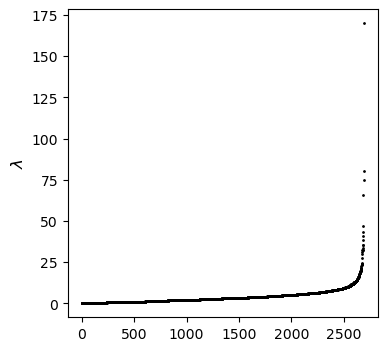

In [21]:
CT.plot_spectrum()

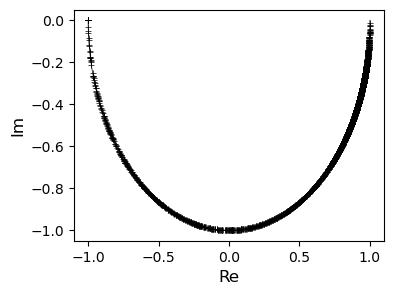

In [22]:
CT.plot_transformed_spectrum()

In [23]:
# C(h * lambda), lambda in spectrum(L)
CT_spectrum = CT.C_spectrum.reshape((1,1,-1))
CT_spectrum.shape

(1, 1, 2708)

In [24]:
c = model.layers[layer].c[0].weight.detach().cpu().numpy()
c.shape

(32, 1433)

In [25]:
# computing the filters of the first layer
cumsum = 0
for k, c_tensor in enumerate( model.layers[layer].c ):
    if k==0:
        c = np.expand_dims( c_tensor.weight.detach().cpu().numpy(), 2 )/2
    else:
        c_re = np.expand_dims( c_tensor.linear_re.weight.detach().cpu().numpy(), 2 )
        c_im = np.expand_dims( c_tensor.linear_im.weight.detach().cpu().numpy(), 2 )
        c = c_re + 1j*c_im
    
    cumsum += 2*( c*(CT_spectrum**(k)) ).real

In [26]:
filter_response = np.copy( cumsum )
# filter_response[input_feature, output_feature, lambda]
filter_response.shape

(32, 1433, 2708)

In [27]:
input_features = filter_response.shape[0]
output_features = filter_response.shape[1]
# there are input_feature*output_feature filters
print('Number of filters: {}'.format(input_features*output_features))

Number of filters: 45856


In [28]:
model

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 32, r=3, normalization=sym)
    (1): CayleyConv(32, 7, r=3, normalization=sym)
  )
)

In [29]:
results = {'model': 'CayleyNet',
           'dataset': dataset.name,
           'training size': sum(train_mask).cpu().numpy(),
           'validation size': sum(val_mask).cpu().numpy(),
           'test size': sum(test_mask).cpu().numpy(),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score,
           'spectrum': CT.C_spectrum,
           'filter response': filter_response
           }

loaded_results = utils.save_results(results, 'filter_'+results['model']+str(results['polynomial order']), results['dataset'])

In [30]:
np.savez_compressed('./results/filter_response', cumsum)

In [31]:
loaded = np.load('./results/filter_response.npz')

In [32]:
filter_response = loaded['arr_0']

In [33]:
filter_response = loaded_results['filter response']

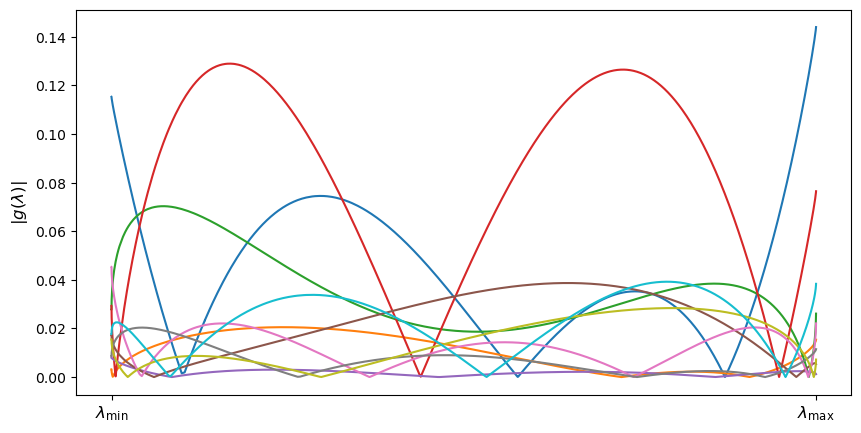

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

idx = []

for _ in range(10):
    i = np.random.randint(input_features)
    j = np.random.randint(output_features)
    idx.append( (i,j) )

    g = np.abs( filter_response[i,j] )
    # w = 10
    # g = np.convolve( g, np.ones(w), 'same' )/w

    plt.plot( CT.C_spectrum.real, g, label='({}, {})'.format(i,j) )
    t = [ CT.C_spectrum.real.min(), CT.C_spectrum.real.max() ]

plt.ylabel(r'$\left| g(\lambda) \right|$', fontsize=12)
plt.xticks(t,[r'$\lambda_{\min}$', r'$\lambda_{\max}$'], fontsize=12)

# plt.legend()
plt.show()

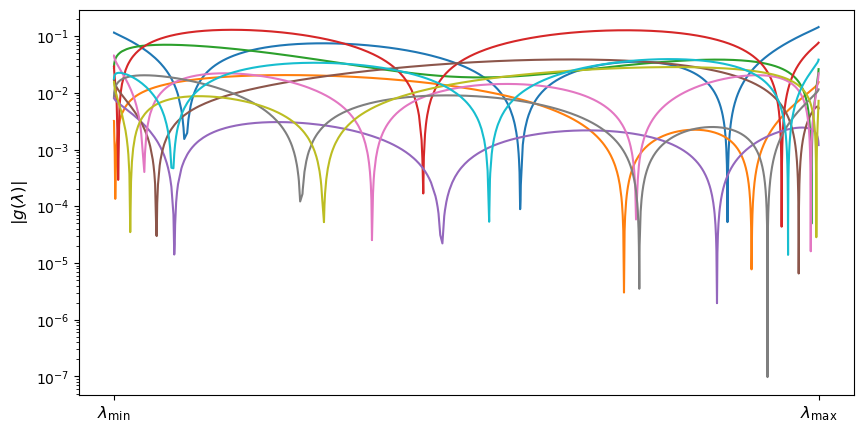

In [35]:
plt.figure(figsize=(10,5))

for i, j in idx:

    g = np.abs( filter_response[i,j] )
    # w = 10
    # g = np.convolve( g, np.ones(w), 'same' )/w

    plt.plot( CT.C_spectrum.real, g, label='({}, {})'.format(i,j) )
    t = [ CT.C_spectrum.real.min(), CT.C_spectrum.real.max() ]

plt.yscale('log')
plt.ylabel(r'$\left| g(\lambda) \right|$', fontsize=12)
plt.xticks(t,[r'$\lambda_{\min}$', r'$\lambda_{\max}$'], fontsize=12)

# plt.legend()
plt.show()

In [155]:
# Sanity check: matrix operations to compute filters

In [156]:
Mteste = np.expand_dims( np.array([[1,2],[3,4]]), (2) )
steste = np.array([0,1,-1]).reshape(1,1,-1)

In [157]:
Mteste

array([[[1],
        [2]],

       [[3],
        [4]]])

In [158]:
Mteste.shape

(2, 2, 1)

In [159]:
Mteste[:,:,0]

array([[1, 2],
       [3, 4]])

In [160]:
steste

array([[[ 0,  1, -1]]])

In [161]:
steste.shape

(1, 1, 3)

In [162]:
result = Mteste*steste

In [163]:
result

array([[[ 0,  1, -1],
        [ 0,  2, -2]],

       [[ 0,  3, -3],
        [ 0,  4, -4]]])

In [164]:
result.shape

(2, 2, 3)

In [165]:
result[:,:,0]

array([[0, 0],
       [0, 0]])

In [166]:
result[:,:,1]

array([[1, 2],
       [3, 4]])

In [167]:
result[:,:,2]

array([[-1, -2],
       [-3, -4]])